<a href="https://colab.research.google.com/github/ricardoV94/mbmlbook/blob/master/MBML_Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
from tqdm import tqdm
plt.rcParams.update({'font.size': 22})

In [0]:
import logging
logger = logging.getLogger('pymc3')
logger.propagate = False
logger.setLevel(logging.ERROR)



---


## 2.2 Testing out the model 

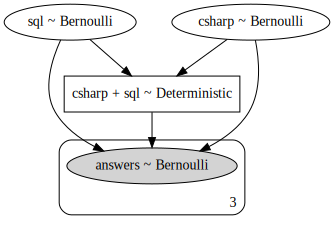

In [0]:
with pm.Model() as model:
   
    csharp = pm.Bernoulli('csharp', p=0.5)
    sql = pm.Bernoulli('sql', p=0.5)
    
    # AND function emulated by multiplying the two variables
    # Equivalent to pm.Deterministic('csharp + sql', csharp * sql)
    both = pm.Deterministic('csharp + sql', tt.prod([csharp, sql]))

    noise = pm.math.switch(tt.stack([csharp, sql, both]), .9, .2)
    answers = pm.Bernoulli('answers', noise, shape=3, observed=[1,0,0])
                
pm.model_to_graphviz(model)

In [0]:
def run_model(data, samples=2000):

    with pm.Model() as model:
       
        csharp = pm.Bernoulli('csharp', p=0.5)
        sql = pm.Bernoulli('sql', p=0.5)
        both = pm.Deterministic('csharp + sql', tt.prod([csharp, sql]))

        noise = pm.math.switch(tt.stack([csharp, sql, both]), .9, .2)
        answers = pm.Bernoulli('answers', noise, shape=3, observed=data)
    
        trace = pm.sample(samples, progressbar=False)

    return trace

def compute_mean(trace, show=2):
    trace_means = []
    for i, var in enumerate(trace.varnames):
        if i==show:
            break
        trace_means.append(trace[var].mean())
    return trace_means

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


[0.79925, 0.0355]


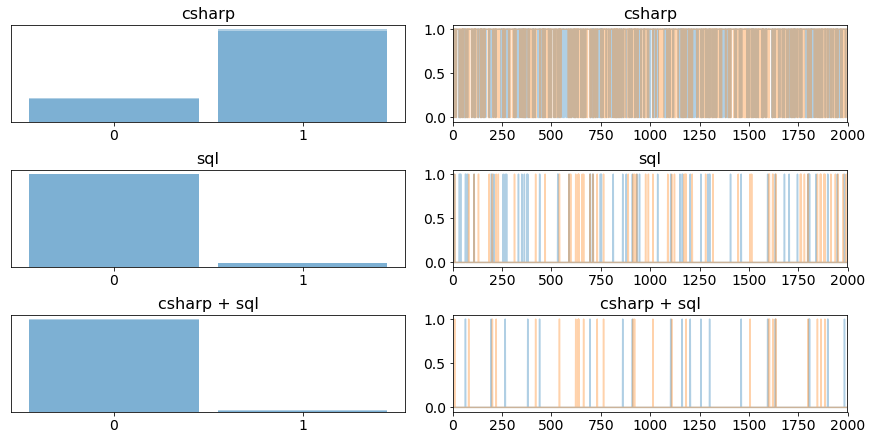

In [0]:
trace = run_model([1, 0, 0])
pm.traceplot(trace)
print(compute_mean(trace))

In [0]:
combs = [[0,0,0], [1,0,0], [0,1,0], [1,1,0], [0,0,1], [1,0,1], [0,1,1], [1,1,1]]
combs_traces = []
for comb in tqdm(combs):
    trace = run_model(comb, samples=2000)
    combs_traces.append(trace)

100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


In [0]:
for comb, trace in zip(combs, combs_traces):
    print(f'Answers: {comb} -> Prob: {compute_mean(trace)}')

Answers: [0, 0, 0] -> Prob: [0.09875, 0.0935]
Answers: [1, 0, 0] -> Prob: [0.80425, 0.03475]
Answers: [0, 1, 0] -> Prob: [0.03875, 0.791]
Answers: [1, 1, 0] -> Prob: [0.56675, 0.56525]
Answers: [0, 0, 1] -> Prob: [0.14225, 0.13775]
Answers: [1, 0, 1] -> Prob: [0.87575, 0.334]
Answers: [0, 1, 1] -> Prob: [0.323, 0.871]
Answers: [1, 1, 1] -> Prob: [0.94875, 0.94675]




---

## 2.3 Loopiness 

(Not a problem with sampling-based inference)

In [0]:
data = [1,0,0,0]

with pm.Model() as model:  
    csharp = pm.Bernoulli('csharp', p=0.5)
    sql = pm.Bernoulli('sql', p=0.5)
    both1 = pm.Deterministic('csharp + sql 1', tt.prod([csharp, sql]))
    both2 = pm.Deterministic('csharp + sql 2', tt.prod([csharp, sql]))
    
    noise = pm.math.switch(tt.stack([csharp, sql, both1, both2]), .9, .2)

    answers = pm.Bernoulli('answers', noise, shape=4, observed=data)
    trace = pm.sample(5000, progressbar=False)

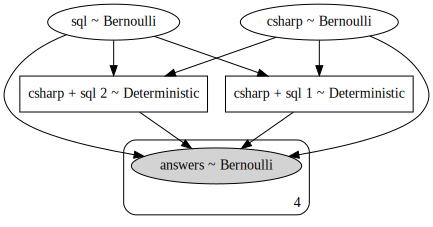

In [0]:
pm.model_to_graphviz(model)

In [0]:
print(f'Answers: {data} -> Prob: {compute_mean(trace)}')

Answers: [1, 0, 0, 0] -> Prob: [0.8059, 0.0201]




---

## 2.4 Moving to real data 

### Visualization

In [0]:
def plot_grid(data, ylabel, xlabel, kwargs={'cmap':'gray', 'vmin':-.3}, create_fig=True):
    
    if create_fig:
        plt.figure(figsize=(14,6))
    extent = (0, data.shape[1], data.shape[0], 0)
    plt.imshow(data, extent=extent, aspect='equal', **kwargs)
    
    for i in range(data.shape[1]):
        plt.axvline(i, color='k')
    for i in range(data.shape[0]):
        plt.axhline(i, color='k')
        
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [0]:
url1 = 'https://raw.githubusercontent.com/ricardoV94/mbmlbook/master/data/Ch2_skills.csv'
url2 = 'https://raw.githubusercontent.com/ricardoV94/mbmlbook/master/data/Ch2_answers.csv'
url3 = 'https://raw.githubusercontent.com/ricardoV94/mbmlbook/master/data/Ch2_skills_self.csv'
df1 = pd.read_csv(url1, header=None)
df2 = pd.read_csv(url2, header=None)
df3 = pd.read_csv(url3, header=None)

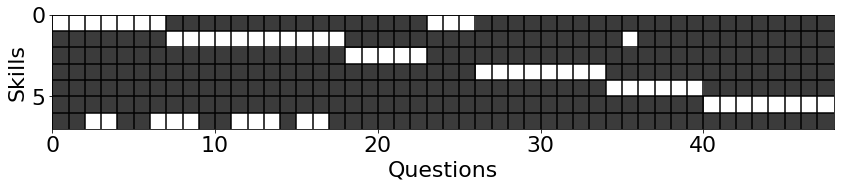

In [0]:
plot_grid(df1.T, 'Skills', 'Questions')

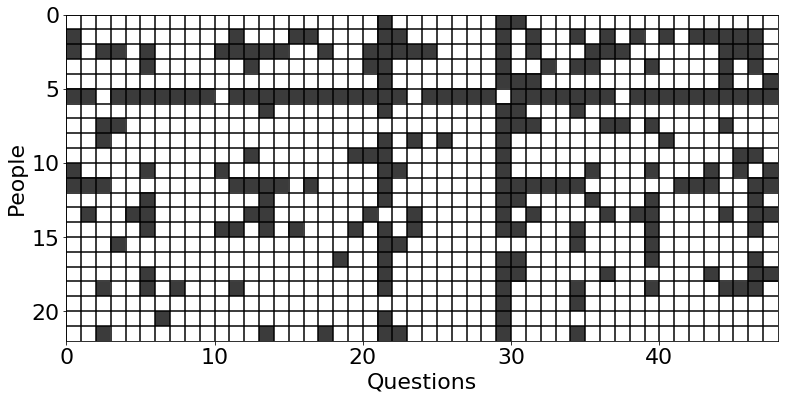

In [0]:
plot_grid(df2.T, 'People', 'Questions')

In [0]:
skills = df1.values
answers = np.array(np.copy(df2.values), dtype=np.float)

for i in range(skills.shape[1]): 
    skill=np.where(skills[:, i]==True)[0]
    
    for j in range(answers.shape[1]):
        answers[:,j][skill] = i
               
answers[df2.values == True] = np.nan

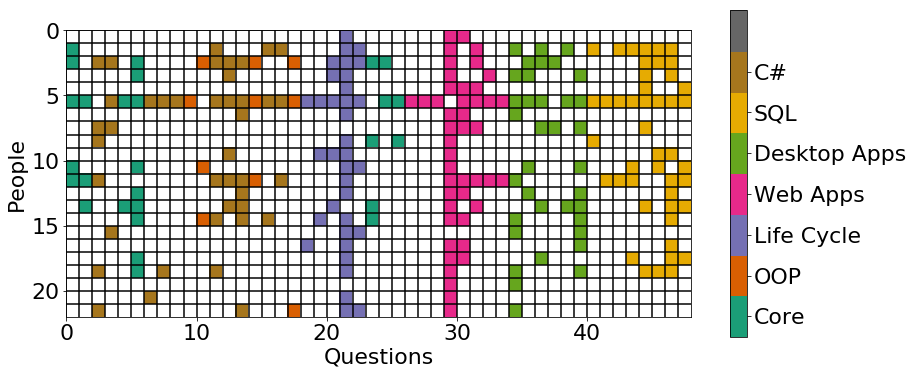

In [0]:
# Shared skills are overriden. 
# There seems to be no straigtforward solution if using matplotlib imshow()

plot_grid(answers.T, 'People', 'Questions', kwargs={'cmap':'Dark2', 'vmax':8})

cbar = plt.colorbar()
cbar.set_ticks(np.arange(7)+.5);
cbar.ax.set_yticklabels(['Core', 'OOP', 'Life Cycle', 'Web Apps', 'Desktop Apps', 'SQL', 'C#']);


### Model

In [0]:
# Ugly hack to combine questions that rely in one or more skills under the same function
max_shared_skills = df1.sum(axis=1).max()
skills_needed = np.zeros((df1.shape[0], max_shared_skills), dtype=np.int)
for i, question in enumerate(df1.values):
    needed = np.where(question == True)[0]
    skills_needed[i] = needed

inferred_skills = np.zeros((22,7))

for i, participant_answers in enumerate(tqdm(df2.values.T)):
    with pm.Model() as model:

        skills = pm.Bernoulli('skills', 0.5, shape=7) 

        # Ugly hack is useful here
        hasSkills = pm.Deterministic('hasSkills', tt.prod(skills[skills_needed], axis=1))  
        
        noise = pm.math.switch(hasSkills, .9, .2)

        answers = pm.Bernoulli('answers', noise, shape=48, observed=participant_answers)

        trace = pm.sample(1000, progressbar=False)
        
    inferred_skills[i] = trace['skills'].mean(axis=0)



  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [00:00<00:00, 10105.65it/s]

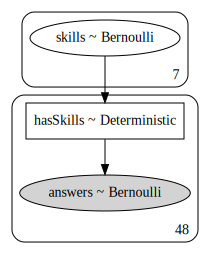

In [0]:
pm.model_to_graphviz(model)

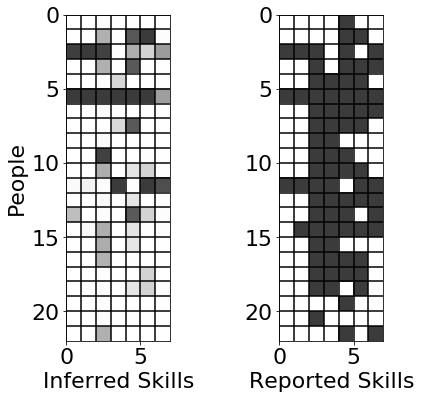

In [0]:
plt.subplots(1,2, figsize=(7,6))
plt.subplot(121)
plot_grid(inferred_skills, 'People', 'Inferred Skills', create_fig=False)
plt.subplot(122)
plot_grid(df3.T, '', 'Reported Skills', create_fig=False)



---


##  2.5 Diagnosing the problem 